In [151]:
import libstempo as lst
import libstempo.toasim as toasim
import libstempo.plot as lstplot
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import sys
import enterprise_GWecc as gwecc
import ephem

In [127]:
data_dir = "/home/abhimanyu/Work/GWecc_sim/DR2/release/VersionB"
par_fmt = "{}.IPTADR2.par"
tim_fmt = "{}.IPTADR2.tim"

output_dir = "output"

if not os.path.exists(output_dir):
    os.mkdir(output_dir)

In [128]:
# Get list of pulsars
psrjs = sorted([os.path.basename(p) for p in glob.glob(data_dir + "/J*")])
print(psrjs)

['J0023+0923', 'J0030+0451', 'J0034-0534', 'J0218+4232', 'J0340+4130', 'J0437-4715', 'J0610-2100', 'J0613-0200', 'J0621+1002', 'J0645+5158', 'J0711-6830', 'J0751+1807', 'J0900-3144', 'J0931-1902', 'J1012+5307', 'J1022+1001', 'J1024-0719', 'J1045-4509', 'J1455-3330', 'J1600-3053', 'J1603-7202', 'J1614-2230', 'J1640+2224', 'J1643-1224', 'J1713+0747', 'J1721-2457', 'J1730-2304', 'J1732-5049', 'J1738+0333', 'J1741+1351', 'J1744-1134', 'J1747-4036', 'J1751-2857', 'J1801-1417', 'J1802-2124', 'J1804-2717', 'J1824-2452A', 'J1832-0836', 'J1843-1113', 'J1853+1303', 'J1857+0943', 'J1903+0327', 'J1909-3744', 'J1910+1256', 'J1911+1347', 'J1911-1114', 'J1918-0642', 'J1923+2515', 'J1939+2134', 'J1944+0907', 'J1949+3106', 'J1955+2908', 'J2010-1323', 'J2017+0603', 'J2019+2425', 'J2033+1734', 'J2043+1711', 'J2124-3358', 'J2129-5721', 'J2145-0750', 'J2214+3000', 'J2229+2643', 'J2302+4442', 'J2317+1439', 'J2322+2057']


In [129]:
def read_pulsar(jname):
    psr_dir = data_dir + "/" + jname
    par_file = psr_dir + "/" + par_fmt.format(jname)
    tim_file = psr_dir + "/" + tim_fmt.format(jname)
    
    psr = lst.tempopulsar(parfile=par_file, timfile=tim_file)
    
    return psr

psrs = []
for psrj in psrjs:
    psr = read_pulsar(psrj)
    psrs.append(psr)

In [130]:
def uniform_sample(n,a,b):
    return np.random.rand(n)*(b-a) + a

efac_min, efac_max = 0.8, 1.2
efacs = uniform_sample(len(psrs), efac_min, efac_max)

log10_equad_min, log10_equad_max = -10, -5
log10_equads = uniform_sample(len(psrs), log10_equad_min, log10_equad_max)
equads = 10**log10_equads

log10_rn_A_min, log10_rn_A_max = -20, -13
log10_rn_As = uniform_sample(len(psrs), log10_rn_A_min, log10_rn_A_max)
rn_As = 10**log10_rn_As

rn_gamma_min, rn_gamma_max = 0.05, 7
rn_gammas = uniform_sample(len(psrs), rn_gamma_min, rn_gamma_max)

rn_nharms = 15

In [149]:
day_to_s = 24*3600

tref = float( max([max(psr.toas()) for psr in psrs]) * day_to_s )

gwecc_params = {"cos_gwtheta" : 0.3,
                "gwphi"       : np.pi/4,
                "log10_dist"  : -1.2,
                "log10_h"     : None,
                "psi"         : 0, 
                "cos_inc"     : 0.6,
                "log10_M"     : 9, 
                "q"           : 1, 
                "log10_F"     : -8, 
                "e0"          : 0.5, 
                "gamma0"      : 0, 
                "l0"          : 0, 
                "tref"        : tref,
                "z"           : 0.0}

def add_gwecc(psr, gwecc_params):
    toas = (psr.toas() * day_to_s).astype("double")
    
    params = dict(zip(psr.pars(), psr.vals()))
    if 'RAJ' in psr.pars():
        theta = float(np.pi/2 - params['DECJ'])
        phi = float(params['RAJ'])
    elif "ELAT" in psr.pars():
        rad_to_deg = 180.0 / np.pi
        coords = ephem.Equatorial(ephem.Ecliptic(str(psr["ELONG"].val * rad_to_deg), str(psr["ELAT"].val * rad_to_deg)))

        theta = np.pi / 2 - float(repr(coords.dec))
        phi = float(repr(coords.ra))
    
    signal = gwecc.eccentric_cw_delay(toas=toas, theta=theta, phi=phi, 
                                      pdist=1, 
                                      psrTerm=False, evolve=True,
                                      **gwecc_params) / day_to_s
    
    psr.stoas[:] += signal 
    
    return signal

In [152]:
for psr, ef, eq, rnA, rngam in zip(psrs, efacs, equads, rn_As, rn_gammas):
    toasim.make_ideal(psr)
    toasim.add_efac(psr, ef)
    toasim.add_equad(psr, eq)
    toasim.add_rednoise(psr, rnA, rngam, components=rn_nharms)
    add_gwecc(psr, gwecc_params)
    print("Simulated TOAs for", psr.name)

Simulated TOAs for J0023+0923
Simulated TOAs for J0030+0451
Simulated TOAs for J0034-0534
Simulated TOAs for J0218+4232
Simulated TOAs for J0340+4130
Simulated TOAs for J0437-4715
Simulated TOAs for J0610-2100
Simulated TOAs for J0613-0200
Simulated TOAs for J0621+1002
Simulated TOAs for J0645+5158
Simulated TOAs for J0711-6830
Simulated TOAs for J0751+1807
Simulated TOAs for J0900-3144
Simulated TOAs for J0931-1902
Simulated TOAs for J1012+5307
Simulated TOAs for J1022+1001
Simulated TOAs for J1024-0719
Simulated TOAs for J1045-4509
Simulated TOAs for J1455-3330
Simulated TOAs for J1600-3053
Simulated TOAs for J1603-7202
Simulated TOAs for J1614-2230
Simulated TOAs for J1640+2224
Simulated TOAs for J1643-1224
Simulated TOAs for J1713+0747
Simulated TOAs for J1721-2457
Simulated TOAs for J1730-2304
Simulated TOAs for J1732-5049
Simulated TOAs for J1738+0333
Simulated TOAs for J1741+1351
Simulated TOAs for J1744-1134
Simulated TOAs for J1747-4036
Simulated TOAs for J1751-2857
Simulated 

In [ ]:
for psr, ef, eq, rnA, rngam in zip(psrs, efacs, equads, rn_As, rn_gammas):
    print(psr.name, ef, eq, rnA, rngam)
    lstplot.plotres(psr)
    plt.show()

In [147]:
('RAJ' and 'DECJ') 

'DECJ'

In [133]:
true_noise_params = np.transpose([psrjs, efacs, equads, rn_As, rn_gammas])
np.savetxt(output_dir + "/true_noise_params.dat", true_noise_params, fmt='%s %s %s %s %s')

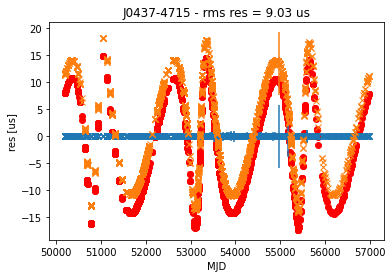

In [138]:
#psr = psrs[5]

#toas = (psr.toas() * day_to_s).astype("double")
#params = dict(zip(psr.pars(), psr.vals()))
#theta = float(np.pi/2 - params['DECJ'])
#phi = float(params['RAJ'])

#signal = gwecc.eccentric_cw_delay(toas=toas, theta=theta, phi=phi, 
#                                  pdist=1, p_dist=1,
#                                  psrTerm=False, evolve=True,
#                                  **gwecc_params)

#toasim.make_ideal(psr)
#lstplot.plotres(psr)

#signal = add_gwecc(psr, gwecc_params)
#lstplot.plotres(psr)

#plt.scatter(psr.toas(),signal*day_to_s*1e6, color='red')

In [39]:
def save_psr_sim(psr):
    print("Writing simulated data for", psr.name)
    psr.savepar("{}/{}_simulate.par".format(output_dir, psr.name))
    psr.savetim("{}/{}_simulate.tim".format(output_dir, psr.name))
    lst.purgetim("{}/{}_simulate.tim".format(output_dir, psr.name))
    
for psr in psrs:
    save_psr_sim(psr)

Writing simulated data for J0023+0923
Writing simulated data for J0030+0451
Writing simulated data for J0034-0534
Writing simulated data for J0218+4232
Writing simulated data for J0340+4130
Writing simulated data for J0437-4715
Writing simulated data for J0610-2100
Writing simulated data for J0613-0200
Writing simulated data for J0621+1002
Writing simulated data for J0645+5158
Writing simulated data for J0711-6830
Writing simulated data for J0751+1807
Writing simulated data for J0900-3144
Writing simulated data for J0931-1902
Writing simulated data for J1012+5307
Writing simulated data for J1022+1001
Writing simulated data for J1024-0719
Writing simulated data for J1045-4509
Writing simulated data for J1455-3330
Writing simulated data for J1600-3053
Writing simulated data for J1603-7202
Writing simulated data for J1614-2230
Writing simulated data for J1640+2224
Writing simulated data for J1643-1224
Writing simulated data for J1713+0747
Writing simulated data for J1721-2457
Writing simu